# Import modules

In [1]:
!pip install einops

In [1]:
import sys, os, yaml
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

# Enter the foldername where all modules are stored together
FOLDERNAME = 'INI - Generative Episodic Memory/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Change the working/current directory
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/INI - Generative Episodic Memory


In [4]:
import torch, torchvision, random, csv, h5py, os, yaml, optuna
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
from data_loader import load_data, load_test
from vqvae import get_model
from tqdm import tqdm
from torch.optim import Adam
from torchvision.utils import make_grid
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import SubsetRandomSampler
from sklearn.model_selection import KFold, train_test_split

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_for_one_epoch(epoch_idx, model, data_loader, optimizer, criterion, config):
    r"""
    Method to run the training for one epoch.
    :param epoch_idx: iteration number of current epoch
    :param model: VQVAE model
    :param data_loader: Data loder for 3dshapes
    :param optimizer: optimzier to be used taken from config
    :param criterion: For computing the loss
    :param config: configuration for the current run
    :return:
    """
    recon_losses = []
    codebook_losses = []
    commitment_losses = []
    losses = []

    for im, label in tqdm(data_loader, desc='Training', leave=False): # Ignore the label in DataLoader
        im = im.float().to(device)
        optimizer.zero_grad()
        model_output = model(im)
        output = model_output['generated_image']
        quantize_losses = model_output['quantized_losses']

        # if config['train_params']['save_training_image']:
        #     cv2.imwrite('input.jpeg', (255 * (im.detach() + 1) / 2).cpu().permute(0, 1, 2, 3).numpy().astype(np.uint8)) #(255 * (im.detach() + 1) / 2).cpu().permute((0, 2, 3, 1)).numpy()[0]
        #     cv2.imwrite('output.jpeg', (255 * (output.detach() + 1) / 2).cpu().permute(0, 1, 2, 3).numpy().astype(np.uint8)) #(255 * (output.detach() + 1) / 2).cpu().permute((0, 2, 3, 1)).numpy()[0]

        recon_loss = criterion(output, im)
        loss = (config['train_params']['reconstruction_loss_weight']*recon_loss +
                config['train_params']['codebook_loss_weight']*quantize_losses['codebook_loss'] +
                config['train_params']['commitment_loss_weight']*quantize_losses['commitment_loss'])
        recon_losses.append(recon_loss.item())
        codebook_losses.append(config['train_params']['codebook_loss_weight']*quantize_losses['codebook_loss'].item())
        commitment_losses.append(quantize_losses['commitment_loss'].item())
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    print('Finished epoch: {} | Recon Loss : {:.4f} | Codebook Loss : {:.4f} | Commitment Loss : {:.4f}'.
          format(epoch_idx + 1,
                 np.mean(recon_losses),
                 np.mean(codebook_losses),
                 np.mean(commitment_losses)))
    return np.mean(losses)


def train(config, sample=None, save_option=True, batch_size, learning_rate):
    ######## Set the desired seed value #######
    seed = config['train_params']['seed']
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if device == 'cuda':
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        # print(args.seed)
    #######################################

    # Create the model and dataset
    model = get_model(config).to(device)
    if sample: data_loader = load_data(config['train_params']['path'],sample_data=sample, shuffle_data=False, batch_size)
    else: data_loader = load_data(config['train_params']['path'])
    num_epochs = config['train_params']['epochs']
    optimizer = Adam(model.parameters(), lr=learning_rate)
    # scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=1, verbose=True)
    criterion = {
        'l1': torch.nn.L1Loss(),
        'l2': torch.nn.MSELoss()
    }.get(config['train_params']['crit'])

    # Create output directories
    if not os.path.exists(config['train_params']['output_dir']):
        os.mkdir(config['train_params']['output_dir'])

    # Train the model
    best_loss = np.inf

    for epoch_idx in range(num_epochs):
        mean_loss = train_for_one_epoch(epoch_idx, model, data_loader, optimizer, criterion, config)
        # scheduler.step(mean_loss)
        # Simply update checkpoint if found better version
        if mean_loss < best_loss:
            print('Improved Loss to {:.4f} .... Saving Model'.format(mean_loss))
            best_loss = mean_loss
        else:
            print('No Loss Improvement')

    # Save the final model and codebook indices
    if save_option:
        all_indices = []
        with torch.no_grad():
            for im, label in tqdm(data_loader, desc='Recall trained model to save codebook indices', leave=False): # Ignore the label in DataLoader
                im = im.float().to(device)
                model_output = model(im)
                indices = model_output['quantized_indices']
                all_indices.append(indices.cpu())

        # Concatenate all indices into a single tensor and save it
        indices_tensor = torch.cat(all_indices, dim=0)
        torch.save(indices_tensor, os.path.join(config['train_params']['output_dir'], config['train_params']['indices_tensor']))

        torch.save(model.state_dict(), os.path.join(config['train_params']['output_dir'], config['train_params']['model_name']))

    # return best_loss

def validate(config, sample, batch_size):
    ######## Load saved model and assign it to a similar structure ########
    state_dict = torch.load(os.path.join(config['train_params']['output_dir'], config['train_params']['model_name']))
    model = get_model(config).to(device)
    model.load_state_dict(state_dict)
    #######################################

    # Validate the model with validation set
    val_loader = load_data(config['train_params']['path'],sample_data=sample, shuffle_data=False, batch_size)
    criterion = {
        'l1': torch.nn.L1Loss(),
        'l2': torch.nn.MSELoss()
    }.get(config['train_params']['crit'])

    # Set model to evaluation mode
    model.eval()
    with torch.no_grad():
        total_recon_loss = 0
        total_codebook_loss = 0
        total_commitment_loss = 0
        total_loss = 0
        for im, label in val_loader:
            im = im.float().to(device)
            model_output = model(im)
            output = model_output['generated_image']

            recon_loss = criterion(output, im)
            quantize_losses = model_output['quantized_losses']

            total_recon_loss += recon_loss.item()
            total_codebook_loss += quantize_losses['codebook_loss'].item()
            total_commitment_loss += quantize_losses['commitment_loss'].item()
            total_loss += (config['train_params']['reconstruction_loss_weight']*recon_loss.item() +
                    config['train_params']['codebook_loss_weight']*quantize_losses['codebook_loss'].item() +
                    config['train_params']['commitment_loss_weight']*quantize_losses['commitment_loss'].item())


        avg_recon_loss = np.mean(total_recon_loss) # / len(val_loader)
        avg_codebook_loss = np.mean(total_codebook_loss) # / len(val_loader)
        avg_commitment_loss = np.mean(total_commitment_loss) # / len(val_loader)
        avg_loss = np.mean(total_loss) # / len(val_loader)
        print('Total Validation Loss : {:.4f} | Recon Loss : {:.4f} | Codebook Loss : {:.4f} | Commitment Loss : {:.4f}'.
              format(avg_loss, avg_recon_loss, avg_codebook_loss, avg_commitment_loss))

        return avg_loss

def assess_test(config, sample):
    ######## Load saved model and assign it to a similar structure ########
    state_dict = torch.load(os.path.join(config['train_params']['output_dir'], config['train_params']['model_name']))
    model = get_model(config).to(device)
    model.load_state_dict(state_dict)
    #######################################

    # Validate the model with validation set
    test_loader = load_data(config['train_params']['path'],sample_data=sample, shuffle_data=False)
    criterion = {
        'l1': torch.nn.L1Loss(),
        'l2': torch.nn.MSELoss()
    }.get(config['train_params']['crit'])

    # Set model to evaluation mode
    model.eval()
    with torch.no_grad():
        total_recon_loss = 0
        total_codebook_loss = 0
        total_commitment_loss = 0
        total_loss = 0
        for im, label in test_loader:
            im = im.float().to(device)
            model_output = model(im)
            output = model_output['generated_image']

            recon_loss = criterion(output, im)
            quantize_losses = model_output['quantized_losses']

            total_recon_loss += recon_loss.item()
            total_codebook_loss += quantize_losses['codebook_loss'].item()
            total_commitment_loss += quantize_losses['commitment_loss'].item()
            total_loss += (config['train_params']['reconstruction_loss_weight']*recon_loss.item() +
                    config['train_params']['codebook_loss_weight']*quantize_losses['codebook_loss'].item() +
                    config['train_params']['commitment_loss_weight']*quantize_losses['commitment_loss'].item())


        avg_recon_loss = np.mean(total_recon_loss) # / len(test_loader)
        avg_codebook_loss = np.mean(total_codebook_loss) # / len(test_loader)
        avg_commitment_loss = np.mean(total_commitment_loss) # / len(test_loader)
        avg_loss = np.mean(total_loss) # / len(test_loader)
        print('Total Test Loss : {:.4f} | Recon Loss : {:.4f} | Codebook Loss : {:.4f} | Commitment Loss : {:.4f}'.
              format(avg_loss, avg_recon_loss, avg_codebook_loss, avg_commitment_loss))

    return avg_loss


def reconstruction(config, test_data) # I have to address test_data
    idxs = torch.randint(0, len(test_dataset), (100, )) # Randomly sample indices for reconstruction.
    ims = torch.cat([test_dataset[idx][0][None, :] for idx in idxs]).float() # Create a batch of images from the test set using sampled indices.
    ims = ims.to(device)

    model_output = model(ims) # Generate reconstructed images.
    generated_ims = model_output['generated_image']
    ims = (ims+1)/2
    generated_ims = (generated_ims + 1) / 2  # Normalize to [0, 1] for visualization

    ## Transform to original value to retrieve colorized data
    ims = ims * 255.0  # Scale to [0, 255]
    generated_ims = generated_ims * 255.0  # Scale to [0, 255]
    ims = ims.cpu().numpy().astype(np.uint8)
    generated_ims = generated_ims.detach().cpu().numpy().astype(np.uint8)  # Detach before converting to NumPy

    # combined_images = torch.hstack([ims, generated_im])
    combined_images = np.concatenate((ims, generated_ims), axis=3)

    # Rearrange to a grid
    combined_images = torch.tensor(combined_images).permute(0, 1, 2, 3)  # Change to [batch, channels, height, width]

    grid = torchvision.utils.make_grid(combined_images, nrow=10, padding=2)

    img = torchvision.transforms.ToPILImage()(grid)
    #img.save('/content/drive/My Drive/INI - Generative Episodic Memory/reconstruction_{model_name}.png'.format(model_name=config['train_params']['model_name']))
    img.save('reconstruction_{model_name}.png'.format(model_name=config['train_params']['model_name']))
    
    #plot the rexonstructions in a large figure
    plt.figure(figsize=(20, 10))
    plt.imshow(img)

    # embedding_weights = model.quantizer.embedding.weight.detach().cpu()
    #torch.save(embedding_weights, 'learned_codebook.pt')

> Best practice to do cross validation and determine hyperparameters


If you want to train your model, fine-tune parameters, and do final evaluation, I recommend you to split your data into training|val|test.

You fit your model using the training part, and then you check different parameter combinations on the val part. Finally, when you're sure which classifier/parameter obtains the best result on the val part, you evaluate on the test to get the final rest.

Once you evaluate on the test part, you shouldn't change the parameters any more.


{'model_params': {'in_channels': 3, 'convbn_blocks': 4, 'conv_kernel_size': [3, 3, 3, 2], 'conv_kernel_strides': [2, 2, 1, 1], 'convbn_channels': [3, 6, 12, 24, 72], 'conv_activation_fn': 'relu', 'transpose_bn_blocks': 4, 'transposebn_channels': [72, 24, 12, 6, 3], 'transpose_kernel_size': [3, 3, 3, 2], 'transpose_kernel_strides': [2, 2, 1, 1], 'transpose_activation_fn': 'relu', 'latent_dim': 72, 'codebook_size': 10}, 'train_params': {'batch_size': 72, 'epochs': 10, 'lr': 0.005, 'crit': 'l2', 'reconstruction_loss_weight': 1, 'codebook_loss_weight': 1, 'commitment_loss_weight': 0.2, 'model_name': 'vqvae_nnL4_cdbk10_ld72.pth', 'indices_tensor': 'vqvae_nnL4_cdbk10_ld72.pt', 'seed': 42, 'save_training_image': True, 'path': '/home/mohsen/Desktop/Academia/RUB Research Projects/INI/data/3dshapes/3dshapes.h5', 'output_dir': 'vqvae_outputs'}}
Total Test Loss : 0.3800 | Recon Loss : 0.0699 | Codebook Loss : 0.2584 | Commitment Loss : 0.2584


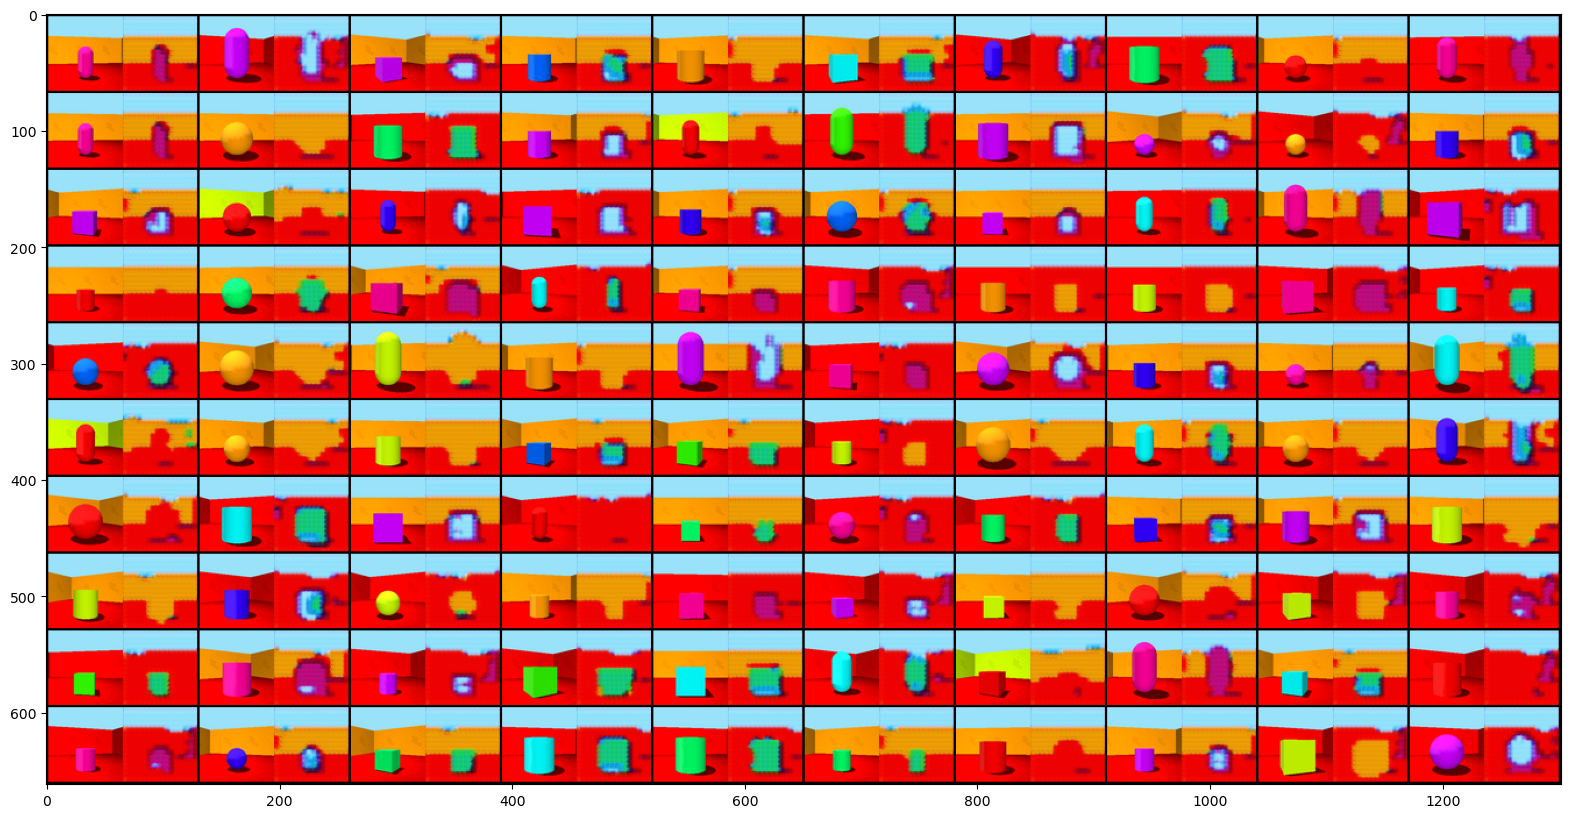

In [5]:
 ######## Read the config file #######
config_path='hyperparameters.yaml'
with open(config_path, 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)
# print(config)

# Load data from the H5 file
h5_file = config['train_params']['path']
with h5py.File(h5_file, 'r') as f:
    images = np.array(f['images'][:10_000,:])
    labels = np.array(f['labels'][:10_000,:])

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=config['train_params']['seed'], shuffle=True)

def objective(trial):
    # Define hyperparameters to tune
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256, 512])
    num_embeddings = trial.suggest_int('num_embeddings', 5, 512)
    commitment_cost = trial.suggest_uniform('commitment_cost', 0.1, 2.0)
    # Initialize KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=config['train_params']['seed'])
    
    train_losses = []
    val_losses = []
    # Get indices for training and validation
    for train_index, val_index in kf.split(train_images):
        # Create samplers
        train_sampler = SubsetRandomSampler(train_index)
        val_sampler = SubsetRandomSampler(val_index)
    
        # train and save model while returning loss_train
        train_loss = train(config, sample=train_sampler)
        train_losses.append(train_loss)
    
        # validate model
        val_loss = validate(config, sample=val_sampler)
        val_losses.append(val_loss)

    # Calculate the average validation loss across folds
    avg_val_loss = np.mean(val_losses)

    return avg_val_loss

# Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Best hyperparameters
print(f"Best hyperparameters: {study.best_params}")




# # Test model and reconstruct image
# test_loss = reconstruction(config, test_images)

# file_name = 'model_assessment.csv'
# # Check if the file exists
# if not os.path.isfile(file_name):
#     # Create the file and write column names
#     with open(file_name, mode='w', newline='') as f:
#         writer = csv.writer(f)
#         writer.writerow(['model_name', 'avg_train_loss', 'avg_val_loss', 'test_loss'])  # Write column names
# else:
#     # Append data to the existing file
#     with open(file_name, mode='a', newline='') as f:
#         writer = csv.writer(f)
#         writer.writerow([config['train_params']['model_name'], sum(val_losses)/len(val_losses), sum(train_losses)/len(train_losses), test_loss])  # Write data
